# Modeling Breast Cancer Subtypes (CNN edition)

In [ ]:
import os
import torch
torch.set_num_threads(4)

import flexynesis 

Here, we demonstrate the capabilities of `flexynesis` on a multi-omic dataset of 2509 Breast Cancer samples from the [METABRIC consortium](https://www.cbioportal.org/study/summary?id=brca_metabric). The data was downloaded from [Cbioportal](https://www.cbioportal.org/study/summary?id=brca_metabric) and randomly split into `train` (70% of the samples) and `test` (30% of the samples) data folders. The data files were processed to follow the same nomenclature. 

- `gex.csv` contains "gene expression" data
- `cna.csv` contains "copy number alteration" data
- `mut.csv` contains "mutation" data, which is a binary matrix of genes versus samples. 
- `clin.csv` contains "clinical/sample metatada", which is a table of clinical parameters such as age, gender, therapy, subtypes. 

## Data Download

The data can be downloaded as follows:

In [ ]:
# if not os.path.exists("brca_metabric_processed"):
#     !wget -O brca_metabric.tgz "https://bimsbstatic.mdc-berlin.de/akalin/buyar/flexynesis-benchmark-datasets/brca_metabric_processed.tgz" && tar -xzvf brca_metabric.tgz

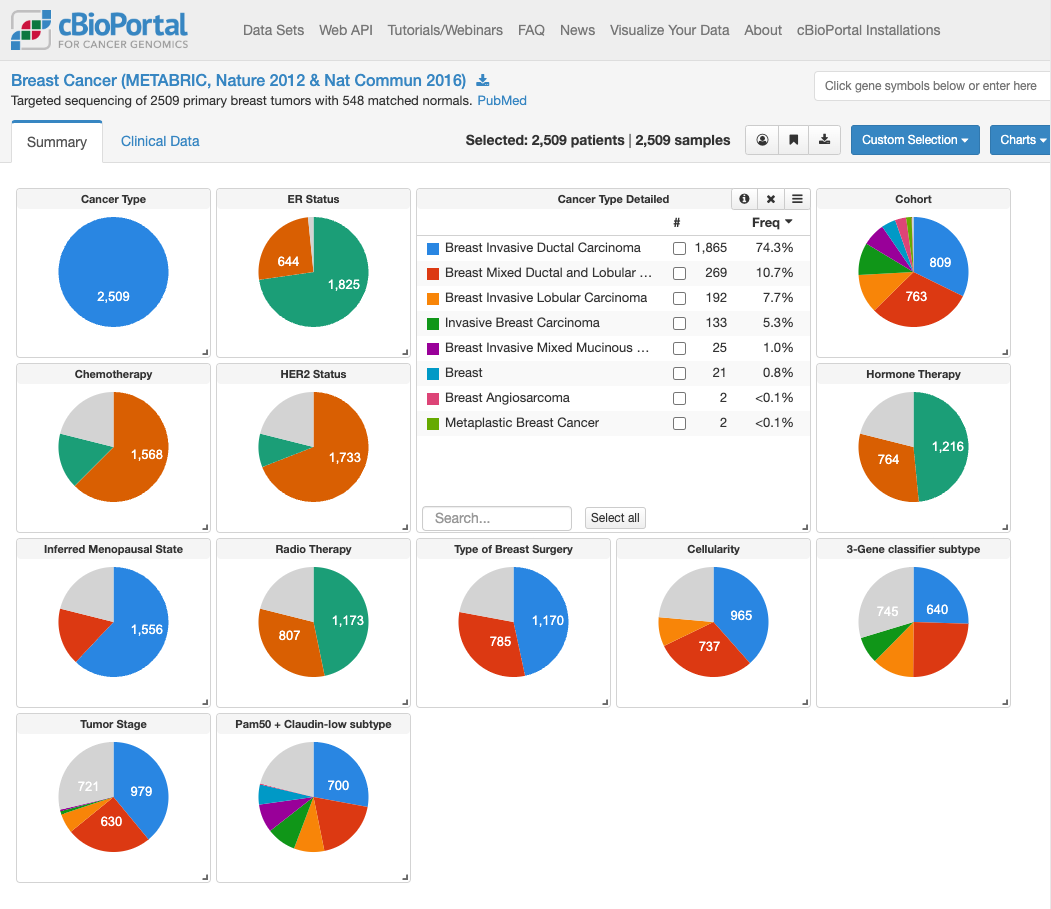

Let's check the number of samples and number of features in the corresponding files under train and test folders:

In [ ]:
# train data
!wc -l ./brca_metabric_processed/train/*

In [ ]:
# test data
!wc -l ./brca_metabric_processed/test/* 

## Importing Multiomics Data Into Flexynesis 

### Procedure
We use the `flexynesis.DataImporter` class to import multiomics data from the data folders. 
Data importing includes:
1. Validation of the data folders
2. Reading data matrices
3. Data processing, which includes: 
    - Cleaning up the data matrices to: 
        - remove uninformative features (e.g. features with near-zero-variation)
        - remove samples with too many NA values 
        - remove features with too many NA values and impute NA values for the rest with few NA values
4. Feature selection **only on training data** for each omics layer separately:
    - Features are sorted by Laplacian score
    - Features that make it in the `top_percentile` 
    - Highly redundant features are further removed (for a pair of highly correlated features, keep the one with the higher laplacian score). 
5. Harmonize the training data with the test data.
    - Subset the test data features to those that are kept for training data 
6. Normalize the datasets 
    - Normalize training data (standard scaling) and apply the same scaling factors to the test data. 
7. (Optional): Log transform the final matrices. 
8. Distinguish numerical and categorical variables in the "clin.csv" file. For categorical variables, create a numerical encoding of the labels for training data. Use the same encoders to map the test samples to the same numerical encodings. 


### Usage

- Here, we import both train/test datasets from the data folder we downloaded and unpacked before. 
- We choose which omic layers to import 
- We choose whether we want to concatenate the data matrices (early integration) or not (intermediate integration) before running them through the neural networks. 
- We want to apply feature selection and keep only top 25% of the features. In the end, we want to keep at least 1000 features per omics layer. 

In [ ]:
data_importer = flexynesis.DataImporter(
    path="./brca_metabric_processed/", 
    data_types=["gex", "cna"], 
    concatenate=False,
    top_percentile=20,
    min_features=1000,
)
train_dataset, test_dataset = data_importer.import_data()

- **dataset.dat** contains the data matrices

In [ ]:
train_dataset.dat

In [ ]:
train_dataset.dat['gex'].shape, train_dataset.dat['cna'].shape

- dataset.ann contains the sample annotation data (from clin.csv), where the keys are variable names and values are tensors. 


In [ ]:
train_dataset.ann

- A mapping of the sample labels for categorical variables can be found in dataset.label_mappings

In [ ]:
train_dataset.label_mappings

- As the data matrices are stored as tensors, the row and column names cannot be stored as tensors. These are stored in the same dataset object as:`dataset.samples` and `dataset.features`

In [ ]:
train_dataset.samples[1:10], train_dataset.features

- We can get a summary of sample metadata using `print_summary_stats`. For categorical variables, we can the sample counts per label and for numerical variables, we get mean/median statistics. 

In [ ]:
flexynesis.print_summary_stats(train_dataset)

## Training flexynesis models

We create a `tuner` object by specifying: 
1. `dataset`: the training dataset (as we constructed above)
2. `model_class`: which model architecture to use:
    a) DirectPred: a fully connected network (standard multilayer perceptron) with supervisor heads (one MLP for each target variable)
    b) Supervised Variational Autoencoder: A variational autoencoder (MMD-loss) with supervisor heads (one MLP for each target variable)
    c) MultiTripletNetwork: A network structured in triplets to enable contrastive learning (using triplet loss) and additiona supervisor heads (one MLP for each target variable)
3. `target_variables`: A comma separated list of target variables (specify the column headers from the clin.csv). 
    - One MLP per each target variable will be created. 
    - The target variables may contain NA values 
4. `config_name`: which hyperparameter search space configuration to use. 
5. `n_iter`: How many hyperparameter search steps to implement. 


- This example runs 1 hyperparameter search step using DirectPred architecture and a hyperparameter configuration space defined for "DirectPred"  with a supervisor head for "CLAUDIN_SUBTYPE" variable:

In [ ]:
tuner = flexynesis.HyperparameterTuning(dataset = train_dataset, 
                                        model_class = flexynesis.DirectPred, 
                                        target_variables = "CLAUDIN_SUBTYPE",
                                        config_name = "DirectPred", 
                                        n_iter=1)    

- We use `perform_tuning` function to run the hyperparameter optimisation procedure. At the end of the parameter optimisation, best model will be selected and returned. 

In [ ]:
model, best_params = tuner.perform_tuning()

One can also visualize the training setting `plot_losses` to `True`. This will print the loss values training/validation splits and also the individual loss values for each target variable. 
In this case, the total loss value for the training equals the loss value of the single variable we chose. 

In [ ]:
tuner = flexynesis.HyperparameterTuning(dataset = train_dataset, 
                                        model_class = flexynesis.DirectPred, 
                                        target_variables = "CLAUDIN_SUBTYPE",
                                        config_name = "DirectPred", 
                                        n_iter=1, plot_losses=True) 
model, best_params = tuner.perform_tuning()

- One can also provide own parameter optimisation spaces via a `yaml` file as input:

In [ ]:
tuner = flexynesis.HyperparameterTuning(dataset = train_dataset, 
                                        model_class = flexynesis.DirectPred, 
                                        target_variables = "CLAUDIN_SUBTYPE",
                                        config_name = "DirectPred", 
                                        n_iter=1, plot_losses=True, 
                                        config_path='./conf.yaml') 
model, best_params = tuner.perform_tuning()

- We can also provide multiple target variables as input. This will create multiple MLP heads (one per variable) and the network will be trained to learn to predict both variables. 

In [ ]:
tuner = flexynesis.HyperparameterTuning(dataset = train_dataset, 
                                        model_class = flexynesis.DirectPred, 
                                        target_variables = "CLAUDIN_SUBTYPE,CHEMOTHERAPY",
                                        config_name = "DirectPred", 
                                        n_iter=1, plot_losses=True,
                                        config_path='./conf.yaml')
model, best_params = tuner.perform_tuning()

- We can mix numerical and categorical variables. The relevant network structure and evaluation procedures will be applied depending on the type of variable

In [ ]:
tuner = flexynesis.HyperparameterTuning(dataset = train_dataset, 
                                        model_class = flexynesis.DirectPred, 
                                        target_variables = "CLAUDIN_SUBTYPE,CHEMOTHERAPY,LYMPH_NODES_EXAMINED_POSITIVE",
                                        config_name = "DirectPred", 
                                        n_iter=1, plot_losses=True,
                                        config_path='./conf.yaml')
model, best_params = tuner.perform_tuning()

### Early Stopping

Training a model longer than needed causes the model to overfit, yield worse validation performance, and also it takes a longer time to train the models, considering if we have to run a long hyperparameter optimisation routine, not just for 1 step, but say more than 100 steps. 

It is possible to set `early stopping` criteria in flexynesis, which is basically a simple callback that is handled by `Pytorch Lightning`. 
This is regulated using the `early_stop_patience`. When set to e.g. 10, the training will stop if the validation loss has not been improved in the last 10 epochs. 

Let's run the model for more HPO steps with early stopping patience set to 10:

In [ ]:
tuner = flexynesis.HyperparameterTuning(dataset = train_dataset, 
                                        model_class = flexynesis.DirectPred, 
                                        target_variables = "CLAUDIN_SUBTYPE",
                                        config_name = "DirectPred", 
                                        n_iter=20, plot_losses=True,
                                        config_path='./conf.yaml', early_stop_patience=20)
model, best_params = tuner.perform_tuning()

In [ ]:
model

In [ ]:
best_params

### Prediction and Model Evaluation

We can use the best model (chosen based on the hyperparameter optimisation procedure) to make predictions on the test dataset

In [ ]:
y_pred_dict = model.predict(test_dataset)

In [ ]:
y_pred_dict

- The predictions are class labels for both variables. Now, we can run `evaluate_wrapper` to evaluate all predictions. 
The wrapper goes through each variable and figures out which type of evaluation to apply to the corresponding variable (whether to report metrics relevant to regression tasks or classification tasks) 

In [ ]:
metrics_df = flexynesis.evaluate_wrapper(y_pred_dict, test_dataset)
metrics_df

### Extracting the sample embeddings

All models trained within `flexynesis` comes with a `transform` method, which extracts the sample embeddings that are generated by the encoding networks (whether it is an MLP or a variational autoencoder). The embeddings reflect a merged representation of multiple omic layers. 

In [ ]:
ds = test_dataset
E = model.transform(ds)

In [ ]:
E.head()

In [ ]:
best_params

### Visualizing the sample embeddings

Let's visualize the embeddings in a reduced space and color by the target variables. 

In [ ]:
f = 'CLAUDIN_SUBTYPE'
labels = [ds.label_mappings[f][x] for x in ds.ann[f].numpy()] #map the sample labels from numeric vector to initial labels. 

In [ ]:
flexynesis.plot_dim_reduced(E, labels, color_type = 'categorical', method='pca')

We can also use UMAP visualisation

In [ ]:
flexynesis.plot_dim_reduced(E, labels, color_type = 'categorical', method='umap')

We can pass further arguments to matplotlib.pyplot.scatter to change the figure parameters  

In [ ]:
flexynesis.plot_dim_reduced(E, labels, color_type = 'categorical', method='umap', scatter_kwargs={'s':100},legend_kwargs={'fontsize': 15}, figsize=(15, 12))

### Feature Importance Calculation (Marker Discovery)

Flexynesis makes use of the `IntegratedGradients` method implemented in the `captum` library to compute the feature importance rankings for a given trained model.
Below, we compute the feature importance for each target variable and class label within the target variable. 

In [ ]:
for var in model.target_variables:
    model.compute_feature_importance(var, steps = 30)

In [ ]:
top_features = flexynesis.get_important_features(model, f, top=10)
top_features

Let's get a subset of the input data for the top features and see if the clusters cluster similarly when we use these features instead of the sample embeddings. 

In [ ]:
import numpy as np 
tf = top_features.groupby('layer')['name'].apply(list).to_dict()
tf = {x: np.unique(tf[x]) for x in tf.keys()} # get unique sets per layer

In [ ]:
df = flexynesis.subset_assays_by_features(ds, tf)

In [ ]:
df

In [ ]:
flexynesis.plot_dim_reduced(df, labels, color_type = 'categorical', method='umap', scatter_kwargs={'s':100}, legend_kwargs={'fontsize': 15}, figsize=(20, 12))